## Advanced ML: Домашнее задание 2

Это задание связано с анализом конкретного датасета, в котором, надеюсь, понадобится то, чему мы с вами до сих пор научились. Как и раньше, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для пользователя snikolenko). Но любые комментарии, новые идеи и рассуждения на тему в этом ноутбуке категорически приветствуются. Датасет давайте возьмём довольно релевантный реальной жизни; он доступен по следующей ссылке:
https://ourworldindata.org/coronavirus-source-data

1. Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).
2. Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.
    1. Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.
    2. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).
    3. Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

### Визаулизация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import datetime
from scipy.stats import multivariate_normal

In [2]:
all_data = pd.read_csv('owid-covid-data.csv')

# select only russia
data = all_data[all_data['iso_code'] == 'RUS']

# change date type
data.loc[:, 'date'] = pd.to_datetime(data['date'])

# select data from 3rd march
data = data[data['date'] >= pd.to_datetime('2020-03-03')]

# select only first N
N = 60
data_test = data[N:]
data = data[:N]

# reaplce zores with ones
is_zero = data.loc[:, 'new_cases'] == 0
data.loc[:, 'new_cases'] += is_zero
data.loc[:, 'total_cases'] += is_zero

/Users/khurshudov/pyvenv/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [3]:
y_train_total_cases = data['total_cases'].values
y_train_log_total_cases = np.log(y_train_total_cases)
X_train = np.array(range(len(y_train_log_total_cases)))

y_test_total_cases = data_test['total_cases'].values
X_test = np.array(range(len(y_train_total_cases), len(y_train_total_cases) + len(y_test_total_cases)))

In [4]:
dt = pd.to_datetime('2020-03-03')
dt_arr = [dt]
for _ in range(300):
    dt_arr.append(dt_arr[-1] + datetime.timedelta(days=1))

dt_arr = [el[5:10] for el in list(map(str, dt_arr))]

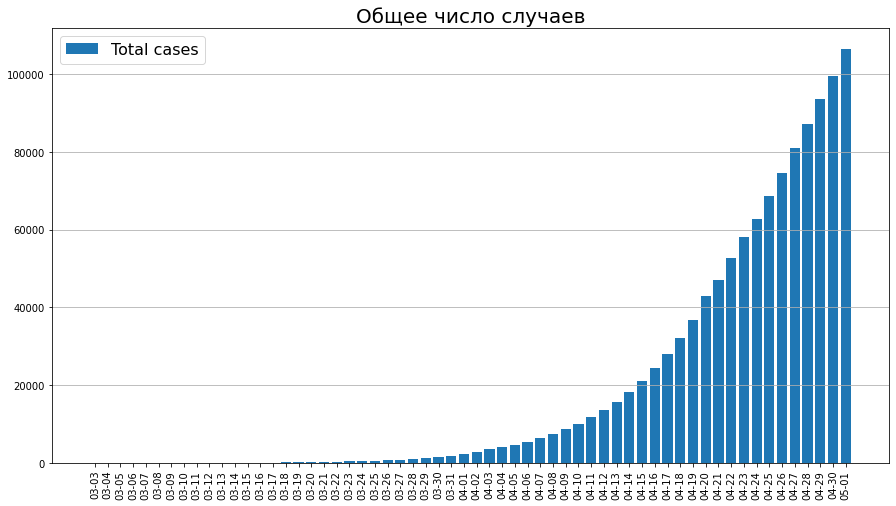

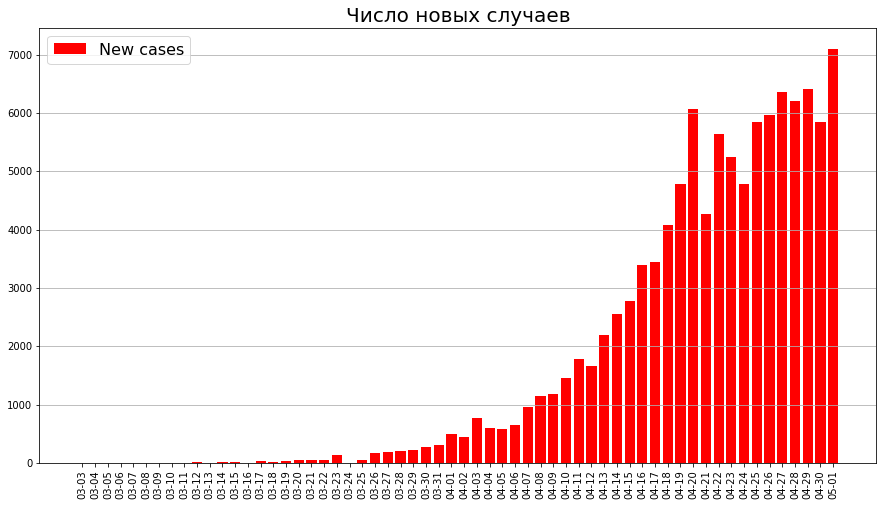

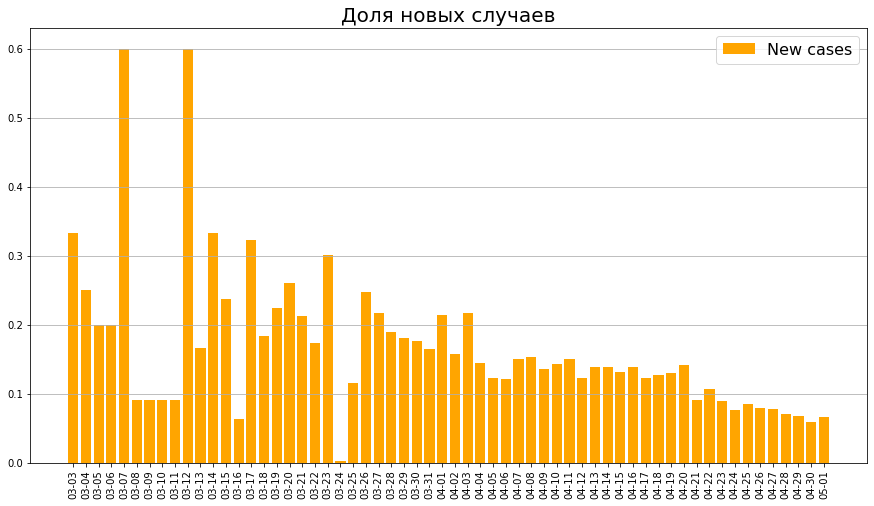

In [5]:
plt.figure(figsize=(15, 8))
plt.grid(axis='y')
plt.title('Общее число случаев', fontsize=20)
plt.bar(X_train, data['total_cases'],
        label='Total cases'
)
plt.xticks(ticks=range(len(X_train)), labels=dt_arr[:len(X_train)], rotation=90)
plt.legend(fontsize=16)
plt.show()


plt.figure(figsize=(15, 8))
plt.grid(axis='y')
plt.title('Число новых случаев', fontsize=20)
plt.bar(X_train, data['new_cases'],
        label='New cases',
        color='red'
)
plt.xticks(ticks=range(len(X_train)), labels=dt_arr[:len(X_train)], rotation=90)
plt.legend(fontsize=16)
plt.show()


plt.figure(figsize=(15, 8))
plt.grid(axis='y')
plt.title('Доля новых случаев', fontsize=20)
plt.bar(X_train, data['new_cases'] / data['total_cases'],
        label='New cases',
        color='orange'
)
plt.xticks(ticks=range(len(X_train)), labels=dt_arr[:len(X_train)], rotation=90)
plt.legend(fontsize=16)
plt.show()

### Посотроение модели

In [6]:
from sklearn.linear_model import LinearRegression, Ridge

model = LinearRegression()
model.fit(X_train.reshape(-1, 1), y_train_log_total_cases)

w1, w0 = model.coef_[0], model.intercept_

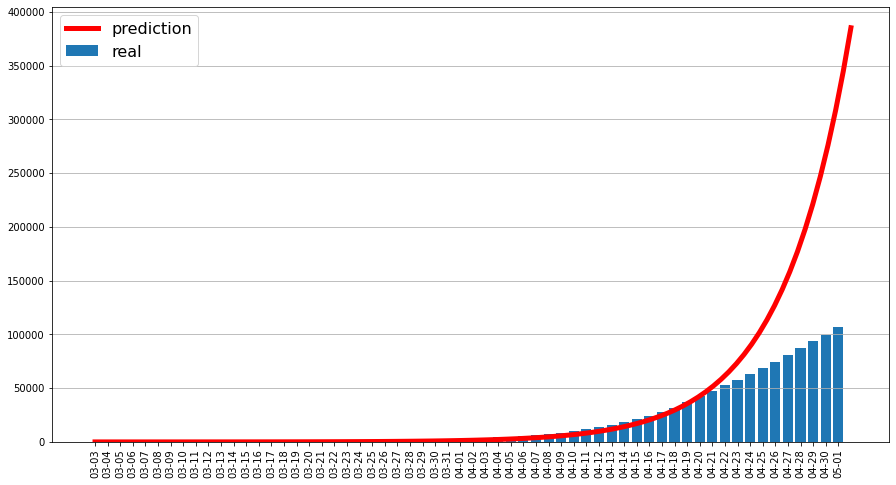

In [7]:
xs = np.linspace(0, N, 100)
    
plt.figure(figsize=(15, 8))
plt.bar(X_train, y_train_total_cases, label='real')
plt.plot(xs, [np.exp(x * w1 + w0)  for x in xs], color = 'red', lw=5, label='prediction')
plt.xticks(ticks=range(len(X_train)), labels=dt_arr[:len(X_train)], rotation=90)
plt.legend(fontsize=16)
plt.grid(axis='y')

### bayes

In [8]:
## Исходная функция
N_f = 250

## X-координаты точек данных
num_points = len(X_train)

In [9]:
xs = np.linspace(-10, N, N_f)
X = np.linspace(-20, 20, N_f)
Y = np.linspace(-20, 20, N_f)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def myplot_heatmap(Z):
    # Make the plot
    plt.axis('equal')
    plt.xlim((-20, 20))
    plt.ylim((0, 10))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)

In [10]:
prior_mu, prior_sigma = np.array([0, 0]), 100*np.array([[1, 0], [0, 1]])
cur_mu, cur_sigma = prior_mu.copy(), prior_sigma.copy()

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

(250, 250)


In [11]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    # plt.axis('equal')
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.4, alpha=.2, color='g')
    plt.ylim((0, 50000))
    plt.xlim((-3, N - 1))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200, zorder=5)

In [12]:
# sigma = np.sqrt(np.std(np.exp(y) - [f(x) for x in X_beg]))
sigma = np.sqrt(np.std(model.predict(X_train.reshape(-1, 1)) - y_train_log_total_cases))
sigma

0.7010153875720916

In [13]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [14]:
cur_mu, cur_sigma = prior_mu.copy(), prior_sigma.copy()

for i in range(N):
    px, py = X_train[i], y_train_log_total_cases[i]
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py, sigma)

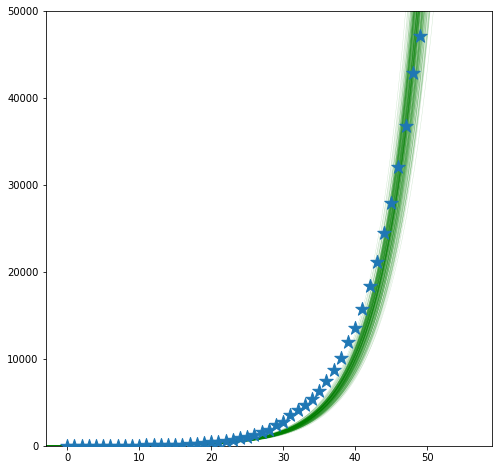

In [15]:
# Посэмплируем и порисуем прямые
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
myplot_sample_lines(cur_mu, cur_sigma, 200, points=[X_train, y_train_total_cases])
# plt.savefig("linregr_bayes5.pdf", bbox_inches="tight")

In [16]:
tmp_N = 2000

date2pred = {}
    
for i in range(len(dt_arr)):
    date2pred[dt_arr[i]] = 0
    
tmp_arr = np.random.multivariate_normal(cur_mu, cur_sigma, tmp_N)
    
for i in range(len(dt_arr)):
#     print(i, dt_arr[i], int(np.exp(i * w1 + w0)))
    tmp = np.array([int(np.exp(i * tmp_w1 + tmp_w0)) for tmp_w0, tmp_w1 in tmp_arr])
    date2pred[dt_arr[i]] = np.mean(tmp), int(np.exp(i * w1 + w0))

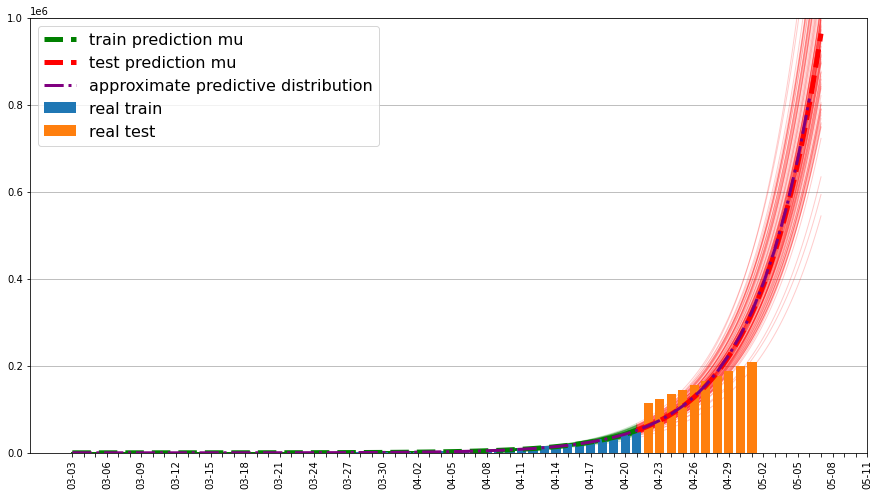

In [17]:
xs = np.linspace(0, 49, 100)
xs_test = np.linspace(49, 65, 100)

w0, w1 = cur_mu
    
plt.figure(figsize=(15, 8))
plt.bar(X_train, y_train_total_cases, label='real train', zorder=5)
plt.bar(list(range(50, 50 + len(y_test_total_cases))), y_test_total_cases, label='real test',zorder=5)

plt.plot(xs, [np.exp(x * w1 + w0)  for x in xs], color = 'green',
         lw=5, label='train prediction mu', ls='--', zorder=6)

plt.plot(xs_test, [np.exp(x * w1 + w0)  for x in xs_test], color = 'red',
         lw=5, label='test prediction mu', ls='--', zorder=6)

plt.plot(range(65), [el[0] for el in date2pred.values()][:65], color='purple',
         lw = 3, label='approximate predictive distribution', ls="dashdot", zorder=7)

for tmp_w0, tmp_w1 in np.random.multivariate_normal(cur_mu, cur_sigma, 100):
    plt.plot(xs, [np.exp(x * tmp_w1 + tmp_w0)  for x in xs], color = 'green',
             lw=1, alpha=.2)
    plt.plot(xs_test, [np.exp(x * tmp_w1 + tmp_w0)  for x in xs_test], color = 'red',
             lw=1, alpha=.2)

tick_labels = [' '] * (len(X_train) + len(X_test))
tick_labels[::3] = dt_arr[:len(X_train) + len(X_test)][::3]

    
plt.xticks(ticks=range(len(X_train)+len(X_test)), labels=tick_labels, rotation=90)
plt.legend(fontsize=16)
plt.ylim(top=1e6)
plt.grid(axis='y')

In [18]:
print(' ' * 23 + 'APD' + ' ' * 14 + 'mu')
print('К 1 мая:       {:15e} | {:15e}'.format(*map(int, date2pred['05-01'])))
print('К 1 июня:      {:15e} | {:15e}'.format(*map(int, date2pred['06-01'])))
print('К 1 сентрября: {:15e} | {:15e}'.format(*map(int, date2pred['09-01'])))

print('APD - approximate predictive distribution')

                       APD              mu
К 1 мая:          3.244880e+05 |    3.207790e+05
К 1 июня:         9.876995e+07 |    9.422532e+07
К 1 сентрября:    2.731606e+15 |    1.988104e+15
APD - approximate predictive distribution


## 3

3. Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана. Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.
    1. Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.
    2. Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.
    3. Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

$$\Phi(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^x e^{-t^2/2}dt$$

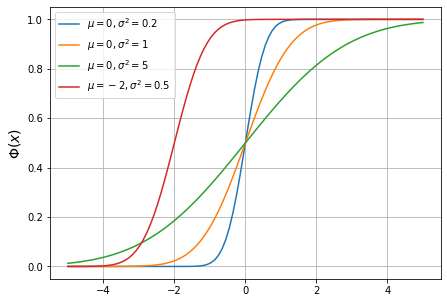

In [19]:
xs = np.linspace(-5, 5, 100)

plt.figure(figsize=(7, 5))
for mu, sg in [(0, .2), (0, 1), (0, 5), (-2, .5)]:
    d = sps.norm(mu, np.sqrt(sg))
    plt.plot(xs, d.cdf(xs), label=r'$\mu={}, \sigma^2={}$'.format(mu, sg))
    
plt.ylabel(r'$\Phi(x)$', fontsize=14)
plt.legend(loc='upper left')
plt.grid()

In [20]:
N = 60

X_train = np.array(list(range(N)))

y_train_new_cases = data['new_cases'].values[:N]
y_train_log_new_cases = np.log(y_train_new_cases)

y_test_new_cases = data_test['new_cases'].values

In [21]:
model = LinearRegression()
model.fit(np.vstack([X_train, X_train**2]).T, y_train_log_new_cases)
sigma_err = np.sqrt(np.std(model.predict(np.vstack([X_train, X_train**2]).T) - y_train_log_new_cases))
sigma_err

0.85609023631908

In [22]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    x_matrix = np.array([[1, x, x**2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [23]:
prior_mu, prior_sigma = np.array([0, 0, 0]), 1000*np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

In [24]:
cur_mu, cur_sigma = prior_mu.copy(), prior_sigma.copy()

for i in range(N):
    px, py = X_train[i], y_train_log_new_cases[i]
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py, sigma_err)

In [25]:
def f(x, w):
    x_matrix = np.array([[x ** i for i in range(len(w))]])
    return np.exp(np.matmul(x_matrix, w))

def f2(x, w):
    x_matrix = np.array([[x ** i for i in range(len(w))]])
    return np.matmul(x_matrix, w)

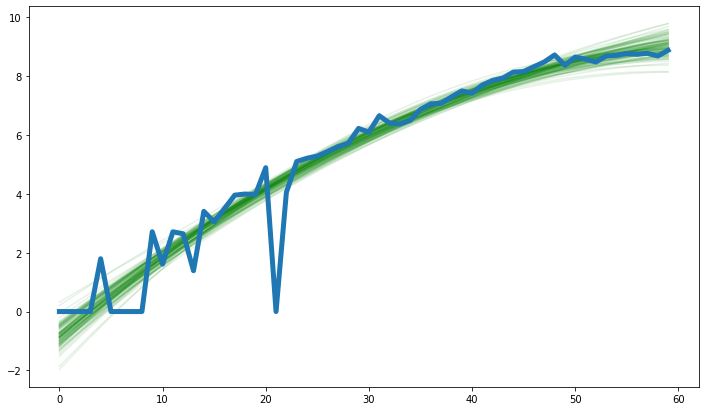

In [26]:
plt.figure(figsize=(12, 7))

plt.plot(y_train_log_new_cases, zorder=5, lw=5)

for tmp_mu in np.random.multivariate_normal(cur_mu, cur_sigma, 100):
    plt.plot([f2(x, tmp_mu) for x in range(N)], color='g', alpha=.1)

In [27]:
n_iter = 200
n_days = 360

pred_arr = []

for tmp_mu in np.random.multivariate_normal(cur_mu, cur_sigma, n_iter):
    tmp_days = []
    for d in range(n_days):
        tmp_days.append(f(d, tmp_mu)[0])
    pred_arr.append(np.array(tmp_days))
    
pred_arr = np.array(pred_arr)

In [28]:
pred_arr[0].shape

(360,)

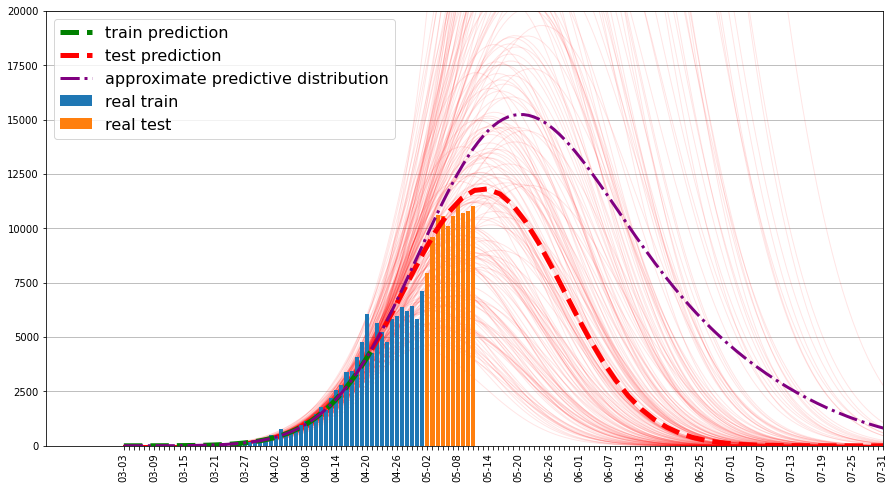

In [29]:
max_day = 300

xs = np.linspace(0, 49, 100)
xs_test = np.linspace(49, max_day, 100)
    
train_pred = [f(x, cur_mu)  for x in xs]
test_pred = [f(x, cur_mu)  for x in xs_test]

xrange = range(200)
    
plt.figure(figsize=(15, 8))
plt.bar(X_train, y_train_new_cases, label='real train', zorder=5)
plt.bar(list(range(N, N + len(y_test_new_cases))), y_test_new_cases, label='real test',zorder=5)

plt.plot(xs, train_pred, color = 'green',
         lw=5, label='train prediction', ls='--', zorder=6)
plt.plot(xs_test, test_pred, color = 'red',
         lw=5, label='test prediction', ls='--', zorder=6)

plt.plot(xrange, pred_arr.mean(axis=0)[:len(xrange)], color='purple',
         lw = 3, label='approximate predictive distribution', ls="dashdot", zorder=7)

for pred_days in pred_arr:
    plt.plot(xrange, pred_days[:len(xrange)], color = 'red',
             lw=1, alpha=.1)

tick_labels = [' '] * (max_day)
tick_labels[::6] = dt_arr[:max_day][::6]
    
plt.xticks(ticks=range(max_day), labels=tick_labels, rotation=90)
plt.legend(fontsize=16)
plt.ylim(top=2e4)
plt.xlim(right=150)
plt.grid(axis='y')

In [30]:
srtd_samples = sorted(pred_arr, key = lambda x:sum(x))

def get_quant_pred(srtd_samples, q):
    return srtd_samples[int(len(srtd_samples) * q)]

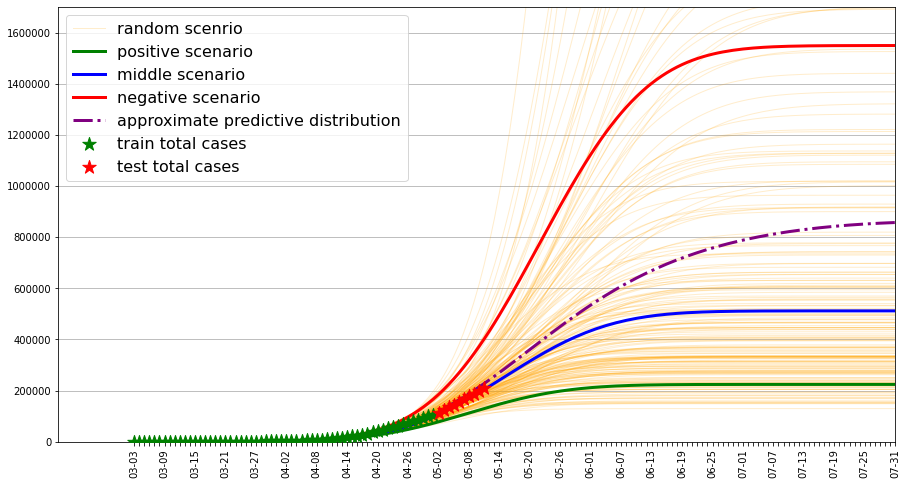

In [31]:
plt.figure(figsize=(15, 8))

xrange = range(300)

plt.scatter(range(N), y_train_total_cases,
            marker='*', s=200, zorder=5, c='g', label='train total cases')
plt.scatter(range(N, N + len(y_test_total_cases)), y_test_total_cases,
            marker='*', s=200, zorder=5, c='r', label='test total cases')

flag = 1
for tmp_mu in np.random.multivariate_normal(cur_mu, cur_sigma, 200):
    pred = np.array([f(x, tmp_mu)[0]  for x in xrange])
    pred = np.cumsum(pred)
    if flag:
        flag = 0
        plt.plot(xrange, pred, color = 'orange', lw=1, alpha=.2, label='random scenrio')
    else:
        plt.plot(xrange, pred, color = 'orange', lw=1, alpha=.2)


## positive
pred = get_quant_pred(srtd_samples, .1).cumsum()
plt.plot(xrange, pred[:len(xrange)], color = 'green',
         lw=3, label ='positive scenario')

## middle
pred = get_quant_pred(srtd_samples, .5).cumsum()
plt.plot(xrange, pred[:len(xrange)], color = 'blue',
         lw=3, label ='middle scenario')

## negative
pred = get_quant_pred(srtd_samples, .9).cumsum()
plt.plot(xrange, pred[:len(xrange)], color = 'red',
         lw=3, label ='negative scenario')

## APD
plt.plot(xrange, pred_arr.mean(axis=0).cumsum()[:len(xrange)], color='purple',
         lw=3, ls='dashdot', label="approximate predictive distribution")
    
    
tick_labels = [' '] * (max_day)
tick_labels[::6] = dt_arr[:max_day][::6]
    
plt.xticks(ticks=range(max_day), labels=tick_labels, rotation=90)
plt.ticklabel_format(style='plain', axis='y')
plt.legend(fontsize=16)
plt.ylim(0, 1700000)
plt.xlim(right=150)
plt.grid(axis='y')

In [32]:
print("При лучшем  (10%) сценарии общее число заболевших будет равно {}"\
      .format(int(srtd_samples[int(len(srtd_samples) * .1)].sum())))
print("При среднем (50%) сценарии общее число заболевших будет равно {}"\
      .format(int(srtd_samples[int(len(srtd_samples) * .5)].sum())))
print("При худшем  (90%) сценарии общее число заболевших будет равно {}"\
      .format(int(srtd_samples[int(len(srtd_samples) * .9)].sum())))

При лучшем  (10%) сценарии общее число заболевших будет равно 224327
При среднем (50%) сценарии общее число заболевших будет равно 511779
При худшем  (90%) сценарии общее число заболевших будет равно 1549081
